# Compute theoretical prediction for xi(r,z=0) from CAMB

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import camb
from camb import model, initialpower

In [3]:
# Cosmology parameters in CoLoRe file (at some point it should read this from CoLoRe files)
h=0.7
Omega_m=0.3
Omega_l=0.7
Omega_b=0.05
w=-1.0
ns=0.96
sigma_8=0.803869
# prepare for CAMB
H0=100.0*h
ombh2=Omega_b*h*h
Omega_c=Omega_m-Omega_b
omch2=Omega_c*h*h

In [4]:
# setup parameters in CAMB
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2)
pars.InitPower.set_params(ns=ns)
default_As=pars.InitPower.ScalarPowerAmp[0]
print('default As=',default_As)
# we need to compute dark matter power to get sigma_8 in default settings
pars.set_matter_power(redshifts=[0.0], kmax=100.0)
default_results = camb.get_results(pars)
default_sigma_8=default_results.get_sigma8()[0]
print('default s8=',default_sigma_8)

default As= 2e-09
default s8= 0.794200800853


In [5]:
# figure out right A_s to get right sigma_8
new_As=default_As*((sigma_8/default_sigma_8)**2)
pars.InitPower.set_params(As=new_As)
new_results = camb.get_results(pars)
new_sigma_8=new_results.get_sigma8()[0]
print('new As=',new_As)
print('new s8=',new_sigma_8)

new As= 2.04899036627e-09
new s8= 0.803869


In [6]:
# return the matter power spectrum at the desired redshift
new_results.calc_power_spectra(pars)
kh, z, pk = new_results.get_matter_power_spectrum(minkh=1e-4, maxkh=10, npoints = 10000)

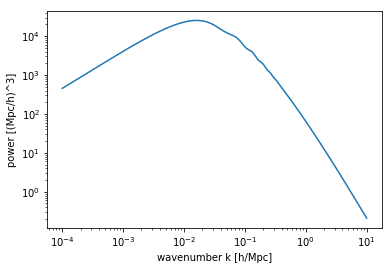

In [7]:
plt.xlabel('wavenumber k [h/Mpc]')
plt.ylabel('power [(Mpc/h)^3]')
plt.loglog(kh,pk[0])

In [8]:
# given an array of P(k), compute integral to get xi(r). It could use a smarter FFT code.
def xi_from_pk(r,ks,Ps,G):
    dlnk=np.log(ks[1])-np.log(ks[0])
    x=ks*r
    fs=(ks**3)*Ps*np.sin(x)/x
    # smooth power at high-k, using Gaussian of width G, to reduce numerical noise
    fs*=np.exp(-(G*ks)**2)
    return np.sum(fs)*(0.5*dlnk/(np.pi**2))  

In [9]:
# smooth power with Gaussian (in Mpc/h)
G=0.5
# will evaluate correlation function at these separations
rs=np.linspace(0.01,200.0,1000)
xis=np.zeros(rs.shape)
for i,r in enumerate(rs):
    xis[i]=xi_from_pk(r,kh,pk[0],G)

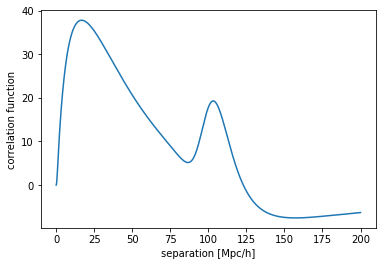

In [10]:
plt.xlabel('separation [Mpc/h]')
plt.ylabel('correlation function')
plt.plot(rs,rs*rs*xis)

In [11]:
# write correlation to file
f = open('camb_xi.txt','w')
for r,xi in zip(rs,xis):
    f.writelines([str(r),' ',str(xi),'\n'])
f.close()